In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Download YOLOv7 repository and install requirements
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt

fatal: destination path 'yolov7' already exists and is not an empty directory.
/content/yolov7


In [3]:
!pip install roboflow supervision==0.18.0 -q

In [4]:
VIDEO_PATH = "/content/drive/MyDrive/Projects/Occupacy analytics/Walmart parking lot, birds eye view by drone (online-video-cutter.com).mp4"

In [5]:
import os
import cv2
import numpy as np
FRAMES_DIR = "/content/frames"
if not os.path.isdir('/content/frames'):
  os.mkdir(FRAMES_DIR)

RESULTS_DIR = "/content/results"
if not os.path.isdir('/content/results'):
  os.mkdir(RESULTS_DIR)

HEATMAPS_DIR = "/content/heatmaps"
if not os.path.isdir('/content/heatmaps'):
  os.mkdir(HEATMAPS_DIR)

GRAPHS_DIR = "/content/graphs"
if not os.path.isdir('/content/graphs'):
  os.mkdir(GRAPHS_DIR)

In [6]:
import supervision as sv
from PIL import Image

frames_generator = sv.get_video_frames_generator(VIDEO_PATH)

for i, frame in enumerate(frames_generator):
  img = Image.fromarray(frame)
  img.save(f"{FRAMES_DIR}/{str(i).zfill(4)}.jpg")

print(f"Saved frames to {FRAMES_DIR}")

Saved frames to /content/frames


In [7]:
import os

def count_files(directory):
    total_files = 0
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            total_files += 1
    return total_files

directory_path = '/content/frames'
total_files = count_files(directory_path)
print("Total files in directory:", total_files)

Total files in directory: 826


In [8]:
# !rm -r /content/frames

## Define Zones

In [9]:
# Polygons From PolygonZone

zones = [
    {
        'name': "Zone 1",
        'polygon': np.array([[4, 90],[130, 90],[130, 675],[6, 675]]),
        'max': 38
    },
    {
        'name': 'Zone 2',
        'polygon': np.array([[200, 70],[320, 70],[320, 675],[200, 675]]),
        'max': 38
    },
    {
        'name': 'Zone 3',
        'polygon': np.array([[395, 50],[530, 50],[530, 675],[395, 675]]),
        'max': 35
    },
    {
        'name': 'Zone 4',
        'polygon': np.array([[600, 50],[725, 50],[725, 675],[600, 675]]),
        'max': 37
    },
    {
        'name': 'Zone 5',
        'polygon': np.array([[800, 43],[925, 43],[925, 675],[800, 675]]),
        'max': 40
    }
]

## Import Model

In [10]:
import numpy as np
import torch
import supervision as sv

from hubconf import custom
model = custom(path_or_model='/content/drive/MyDrive/Projects/Occupacy analytics/trained/best_weight.pt')  # custom example

def callback(frame: np.ndarray) -> sv.Detections:
    results = model(frame)
    # pred = non_max_suppression(results, 0.33, 0.45, classes=None, agnostic= True)
    detections = sv.Detections.from_yolov5(results)
    return detections

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Adding autoShape... 


In [11]:
tracker = sv.ByteTrack()
slicer = sv.InferenceSlicer(
    callback=callback,
    slice_wh=(800, 800),
    overlap_ratio_wh=(0.6, 0.6),
    thread_workers=1,
    iou_threshold=0.2
)
triangle_annotator = sv.TriangleAnnotator(
    base=8,
    height=8,
)
heat_map_annotator = sv.HeatMapAnnotator()

def setup_zones(frame_wh):
  if zones:
    for zone in zones:
      zone['history'] = []
      zone['PolygonZone'] = sv.PolygonZone(
          polygon=zone['polygon'],
          frame_resolution_wh=frame_wh
      )
      zone['PolygonZoneAnnotator'] = sv.PolygonZoneAnnotator(
        zone=zone['PolygonZone'],
        color=sv.Color.WHITE,
        thickness=2,
        text_padding=7,
        text_scale=0.4
    )

def process_frame(frame,heatmap=None):
    detections = slicer(image=frame)
    # print(detections)
    detections = tracker.update_with_detections(detections)

    annotated_frame = frame.copy()

    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )

    if heatmap is None:
      heatmap = np.full(frame.shape, 255, dtype=np.uint8)

    heat_map_annotator.annotate(
      scene=heatmap,
      detections=detections
    )

    if zones:
      for zone in zones:
        zone_presence = zone['PolygonZone'].trigger(detections)
        zone_present_idxs = [idx for idx, present in enumerate(zone_presence) if present]
        zone_present = detections[zone_present_idxs]

        zone_count = len(zone_present)
        zone['history'].append(zone_count)


        annotated_frame = zone['PolygonZoneAnnotator'].annotate(
            scene=annotated_frame,
            label=f"{zone['name']}: {zone_count}"
        )

        # Heatmap
        heatmap = zone['PolygonZoneAnnotator'].annotate(
            scene=heatmap,
            label=" "
        )

    return annotated_frame, heatmap

## Process One image


array([[[129, 128, 132],
        [129, 128, 132],
        [129, 128, 132],
        ...,
        [107, 106, 116],
        [107, 106, 116],
        [107, 106, 116]],

       [[129, 128, 132],
        [129, 128, 132],
        [129, 128, 132],
        ...,
        [107, 106, 116],
        [107, 106, 116],
        [107, 106, 116]],

       [[129, 128, 132],
        [129, 128, 132],
        [129, 128, 132],
        ...,
        [107, 106, 116],
        [107, 106, 116],
        [107, 106, 116]],

       ...,

       [[ 73,  71,  77],
        [ 83,  81,  87],
        [ 97,  95, 101],
        ...,
        [131, 132, 142],
        [131, 132, 142],
        [131, 132, 142]],

       [[ 74,  72,  78],
        [ 77,  75,  81],
        [ 80,  78,  84],
        ...,
        [130, 131, 141],
        [130, 131, 141],
        [130, 131, 141]],

       [[ 72,  70,  76],
        [ 74,  72,  78],
        [ 78,  76,  82],
        ...,
        [130, 131, 141],
        [130, 131, 141],
        [130, 131, 141]]], dtype=uint8)
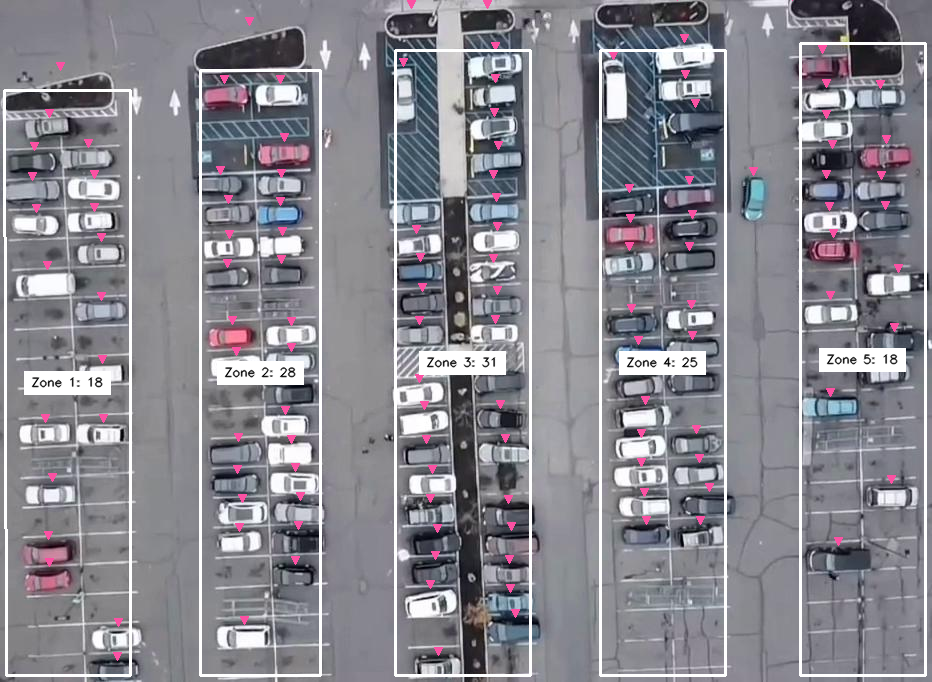

In [12]:
image = cv2.imread("/content/frames/0510.jpg")
image_wh = (image.shape[1],image.shape[0])
setup_zones(image_wh)

annotated_image, heatmap = process_frame(image)

# sv.plot_image(annotated_image)
# sv.plot_image(heatmap)
annotated_image

## Setup Graphs

In [13]:
# Credit to https://matplotlib.org/matplotblog/posts/matplotlib-cyberpunk-style/ for graph styles
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def generate_graphs(max_frames):
  # Plot Styles
  plt.style.use("seaborn-v0_8-dark")
  for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
      plt.rcParams[param] = '#212946'

  for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
      plt.rcParams[param] = '0.9'


  dataframe = pd.DataFrame()
  graphs = {}


  for zone in zones:
    percentage_history = [(count/zone['max'])*100 for count in zone['history']]
    dataframe[zone['name']] = percentage_history
    plt.title(f'{zone["name"]} Usage')

    # Extra Styles
    fig, ax1 = plt.subplots()
    ax1.grid(color='#2A3459')

    # Data
    ax1.plot(zone["history"])

    # Axis Labeling
    plt.ylabel('Vehicles')
    plt.ylim(top=zone["max"])
    plt.xlim(right=max_frames)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Occupied Percentage (%)')

    # Export Graph Image
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    graphs[zone['name']] = Image.open(buf)
    plt.close(fig)

  dataframe.plot()

  # Axis
  plt.ylabel('Occupied (%)', fontsize=15)
  plt.ylim(top=100)
  plt.xlim(right=max_frames)

  # Export combined
  buf = BytesIO()
  plt.savefig(buf, format='png', bbox_inches='tight')
  buf.seek(0)

  plt.close()

  graphs['combined_percentage'] = Image.open(buf)

  return graphs

## Process the frames

  0%|          | 1/826 [00:25<5:56:23, 25.92s/it]


KeyboardInterrupt: 

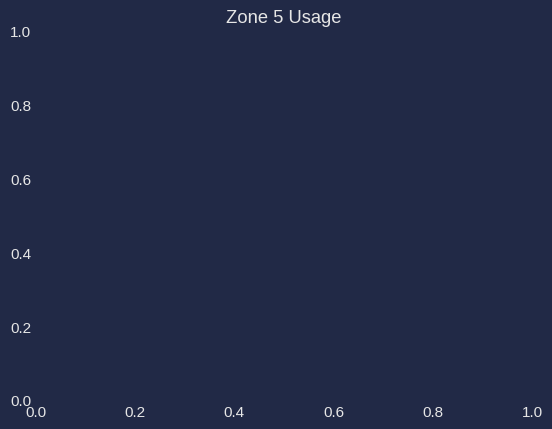

In [15]:
import os
from tqdm import tqdm
from PIL import Image

directory = '/content/frames'
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])

totalFrames = 826  # Total no.of frames to detect

# image = cv2.imread("/content/frames/0000.jpg")
# image_wh = (image.shape[1],image.shape[0])
# setup_zones(image_wh)
# Loop through files in the directory
for filename in tqdm(files[:totalFrames]):
    # Check if the current item is a file
    if os.path.isfile(os.path.join(directory, filename)):
        image = cv2.imread("/content/frames/"+filename)

        annotated_image, heatmap  = process_frame(image)

        # Create result images
        image = Image.fromarray(np.uint8(annotated_image))
        image.save('/content/results/'+filename)

        # Create Heatmaps
        heatMap = Image.fromarray(np.uint8(heatmap))
        heatMap.save('/content/heatmaps/'+filename)

        # Create Graphs
        graphs = generate_graphs(totalFrames)
        graph = graphs["combined_percentage"].convert("RGB")
        graph.save("/content/graphs/"+filename)



## Create video from frames

In [ ]:
# !rm /content/graphs/*

In [ ]:
import cv2
import os

def images_to_video(image_folder, output_video, fps=30):
    # Get list of images in the directory
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    images.sort()  # Sort images by name

    # Get the size of the first image
    first_image_path = os.path.join(image_folder, images[0])
    frame = cv2.imread(first_image_path)
    height, width, layers = frame.shape

    # Initialize the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for image in images:
        image_path = os.path.join(image_folder, image)
        frame = cv2.imread(image_path)
        video.write(frame)  # Write the frame to the video

    video.release()  # Release the video writer
    print(f'Video saved as {output_video}')

# Example usage

images_to_video('/content/results', '/content/results.mp4', fps=20)

images_to_video('/content/heatmaps', '/content/heatmaps.mp4', fps=20)

images_to_video('/content/graphs', '/content/graphs.mp4', fps=20)

In [ ]:
!cp '/content/results.mp4' '/content/drive/MyDrive/Projects/Occupacy analytics/'
!cp '/content/heatmaps.mp4' '/content/drive/MyDrive/Projects/Occupacy analytics/'
!cp '/content/graphs.mp4' '/content/drive/MyDrive/Projects/Occupacy analytics/'

## Process the entire video

In [ ]:
MAIN_OUTPUT_PATH = "/content/parkinglot_annotated.mp4"
frames_generator = sv.get_video_frames_generator(source_path=VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

setup_zones(video_info.resolution_wh)


with sv.VideoSink(target_path=MAIN_OUTPUT_PATH, video_info=video_info) as sink:
  heatmap = None
  for i, frame in enumerate(frames_generator):
    print(f"Processing frame {i}")

    # Infer
    annotated_frame, heatmap = process_frame(frame, heatmap)

    # Save the latest heatmap
    Image.fromarray(heatmap).save(f"/content/heatmaps/{i}.jpg")

    # Create Graphs
    graphs = generate_graphs(video_info.total_frames)
    graph = graphs["combined_percentage"].convert("RGB")
    graph.save(f"/content/graphs/{i}.jpg")

    # sv.plot_image(annotated_frame)

    # Send as frame to video
    sink.write_frame(frame=annotated_frame)

## Occupancies

In [ ]:
# Occupancy for each zone

import statistics
for zone in zones:
    occupancy_percent_history = [(count/zone['max'])*100 for count in zone['history']]
    average_occupancy = round(statistics.mean(occupancy_percent_history))
    median_occupancy = round(statistics.median(occupancy_percent_history))
    highest_occupancy = round(max(occupancy_percent_history))
    lowest_occupancy = round(min(occupancy_percent_history))
    print(f"{zone['name']} had an average occupancy of {average_occupancy}% with a median occupancy of {median_occupancy}%.")

In [ ]:
## Occupancy for all zones

lot_history = []
for zone in zones:
    for idx, entry in enumerate(zone['history']):
      if(idx >= len(lot_history) or len(lot_history)==0): lot_history.append([])
      lot_history[idx].append(zone['history'][idx]/zone['max'])

lot_occupancy_history = [sum(entry)/len(entry)*100 for entry in lot_history]

average_occupancy = round(statistics.mean(lot_occupancy_history))
median_occupancy = round(statistics.median(lot_occupancy_history))
highest_occupancy = round(max(lot_occupancy_history))
lowest_occupancy = round(min(lot_occupancy_history))

print(f"The entire lot had an average occupancy of {average_occupancy}% with a median occupancy of {median_occupancy}%.")